# Topic Modeling 1

climate_tweets.csv

column of focus: `tweet`: raw text

---

1. Load data
2. EDA:

   - Detect and analyze retweets
   - Extract user mentions and hashtags
   - Explore hashtag frequency and correlations
3. Text cleaning for Topic Modeling
4. Convert text to vectors (not TF-IDF)
5. Apply LDA Topic Modeling
6. Show top keywords per topic
7. Visualization of topic keywords
8. Additional: stem completion for text cleaning

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

### 1. Load the Data

In [5]:
df = pd.read_csv('Data/climate_tweets.csv')

df.head()

,tweet
0,Global warming report urges governments to act...
1,Fighting poverty and global warming in Africa ...
2,Carbon offsets: How a Vatican forest failed to...
3,Carbon offsets: How a Vatican forest failed to...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...


In [16]:
df['tweet'][0]

'Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]'

In [19]:
df['tweet'][-2:-1]

6088    One-Eyed Golfer: Don't dare tell me about glob...
Name: tweet, dtype: object

In [17]:
df.shape

(6090, 1)

## 2.EDA

In [20]:
# make a new column to highlight retweets
# tweets starting with "RT" are retweets

df['is_retweet'] = df['tweet'].apply(lambda x: x[:2] == 'RT')

In [21]:
# number of retweets

print(f"Number of retweets: {df['is_retweet'].sum()}")

Number of retweets: 773


In [22]:
# number of unique retweets

print('Unique retweets:', df.loc[df['is_retweet']].tweet.unique().size)

Unique retweets: 677


In [23]:
# 10 most repeated tweets

print('Top 10 repeated tweets:')
print(df.groupby(['tweet'])
      .size()
      .reset_index(name='counts')
      .sort_values('counts', ascending = False)
      .head(10)
     )

Top 10 repeated tweets:
                                                  tweet  counts
3131  No matter if you believe in global warming or ...      20
4555  Take Action @change: Help Protect Wildlife Hab...      14
4027  RT @newtgingrich: Historic snow storm in washi...       9
1765       Fight Climate Change From All Fronts: [link]       8
1626  Earth's polar ice sheets vulnerable to even mo...       7
1941  Global Warming Dent's El Ni'o's Protective Shi...       7
1799  Foes of California's global warming law pour m...       6
1351  Coalition of the Tired of Waiting: Fighting Cl...       6
4271  SCIENCE: Scientists explore the evolution of c...       6
1040  Carbon offsets: How a Vatican forest failed to...       6


In [33]:
# Histogram showing distribution of tweet repetition

counts = df['tweet'].value_counts().values
my_bins = np.arange(0, counts.max() + 2, 1) - 0.5

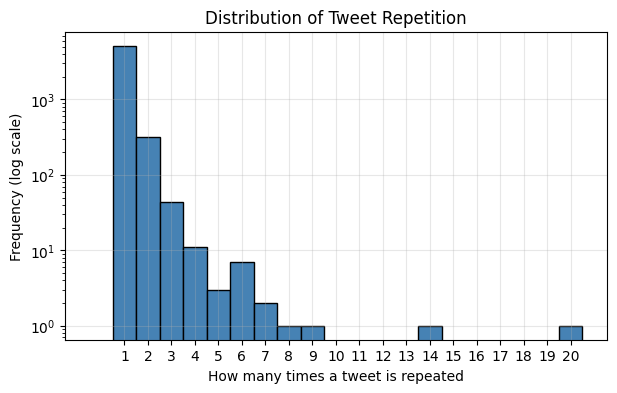

In [34]:
plt.figure(figsize=(7, 4))
plt.hist(counts, bins=my_bins, color = 'steelblue', edgecolor='black')
plt.xlabel('How many times a tweet is repeated')
plt.ylabel('Frequency (log scale)')
plt.yscale('log', nonpositive='clip')
plt.title('Distribution of Tweet Repetition')
plt.xticks(np.arange(1, counts.max() + 1, 1))
plt.grid(alpha=0.3)
plt.show()

### Extract retreived users, mentions, and hashtags

In [35]:
# who is being retweeted?
# extract retweeted usernames
#
# regexp (?<=...) is positive lookbehind:
# match something if it is preceded by a specific pattern
def find_retweeted(tweet):
    return re.findall(r'(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-])', tweet)

In [36]:
# who is being mentioned?
# extract mentioned usernames
# 
# regexp (?<!...) is negative lookbehind:
# match something if it is NOT preceded by a specific pattern
def find_mentioned(tweet):
    return re.findall(r'(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [37]:
# what hashtags are being used?
# extract hashtags
def find_hashtags(tweet):
    return re.findall(r'(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [41]:
# make new columns
df['retweeted'] = df['tweet'].apply(find_retweeted)
df['mentioned'] = df['tweet'].apply(find_mentioned)
df['hashtags'] = df['tweet'].apply(find_hashtags)

In [42]:
df.head()

,tweet,is_retweet,retweeted,mentioned,hashtags
0,Global warming report urges governments to act...,False,[],[],[]
1,Fighting poverty and global warming in Africa ...,False,[],[],[]
2,Carbon offsets: How a Vatican forest failed to...,False,[],[],[]
3,Carbon offsets: How a Vatican forest failed to...,False,[],[],[]
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,False,[],[],[]


In [43]:
df.tail()

,tweet,is_retweet,retweeted,mentioned,hashtags
6085,"@bloodless_coup ""The phrase 'global warming' s...",False,[],[@bloodless_coup],"[#p2, #tcot]"
6086,Virginia to Investigate Global Warming Scienti...,False,[],[],[]
6087,Global warming you tube parody you will enjoy ...,False,[],[],"[#IPCC, #ocra]"
6088,One-Eyed Golfer: Don't dare tell me about glob...,False,[],[],[]
6089,man made global warming a hair brained theory ...,False,[],[],"[#tcot, #p2, #climategate]"


### Hashtag Analysis

In [44]:
# keep only rows containing hashtags
# (non-empty hashtag lists)

hashtags_list_df = df.loc[df['hashtags'].str.len() > 0, ['hashtags']]

In [46]:
hashtags_list_df.head()

,hashtags
12,"[#Climate, #population]"
16,[#EarthDay]
26,[#ac]
31,[#tcot]
36,"[#tornadocot, #ocra, #sgp, #gop, #ucot, #tlot,..."


In [48]:
# expand lists of hashtags into rows
# (dataframe where each hashtag gets its own row)
hashtag_rows_df = (
    hashtags_list_df
    .explode('hashtags')
    .rename(columns = {'hashtags' : 'hashtag'})
)

In [51]:
print(f'Number of unique hashtags: {hashtag_rows_df['hashtag'].nunique()}')
hashtag_rows_df.head(10)

Number of unique hashtags: 477


,hashtag
12,#Climate
12,#population
16,#EarthDay
26,#ac
31,#tcot
36,#tornadocot
36,#ocra
36,#sgp
36,#gop
36,#ucot


In [52]:
# count frequency of each hashtag
popular_hashtags = (
    hashtag_rows_df
    .groupby('hashtag')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending = False)
    .reset_index(drop = True)
)

In [53]:
print('Top 10 hashtags:')
popular_hashtags.head(10)

Top 10 hashtags:


,hashtag,counts
0,#tcot,227
1,#climate,202
2,#p2,112
3,#green,50
4,#climatechange,47
5,#teaparty,41
6,#global,40
7,#eco,40
8,#SaveTerra,36
9,#climategate,33


In [54]:
# Histogram showing hashtag counts

counts = popular_hashtags['counts']
my_bins = np.arange(0, counts.max() + 2, 5) - 0.5

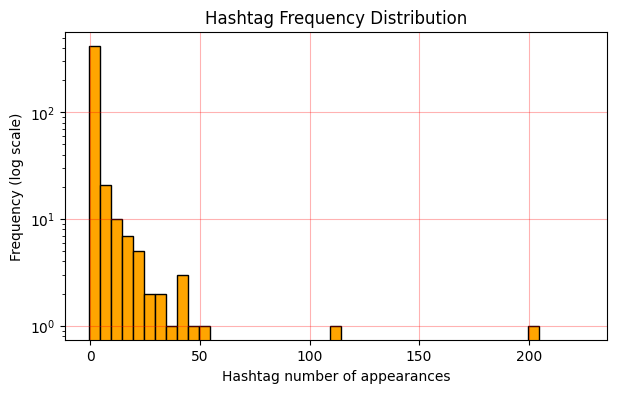

In [61]:
plt.figure(figsize=(7, 4))
plt.hist(counts, bins = my_bins, color = 'orange', edgecolor = 'black', alpha = 1.0)
plt.xlabel('Hashtag number of appearances')
plt.ylabel('Frequency (log scale)')
plt.yscale('log', nonpositive = 'clip')
plt.title('Hashtag Frequency Distribution')
plt.grid(alpha = 0.3, color='red')
plt.show()

Find most frequent hashtags and check their correlation

In [62]:
# Filter popular hashtags
# minimum appearances threshold

min_appearance = 10

In [63]:
# create a set of popular hashtags

popular_hashtags_set = set(
    popular_hashtags
    .loc[
        popular_hashtags['counts'] >= min_appearance,
        'hashtag'
    ]
)

In [64]:
# keep only popular hashtags in each list

hashtags_list_df['popular_hashtags'] = hashtags_list_df['hashtags'].apply(
    lambda lst: [tag for tag in lst if tag in popular_hashtags_set]
)

In [66]:
# drop rows without any popular hashtag

popular_hashtags_list_df = hashtags_list_df.loc[
    hashtags_list_df['popular_hashtags'].str.len()>0
]

In [67]:
# make a new dataframe for one-hot encoding

hashtag_vector_df = popular_hashtags_list_df[['popular_hashtags']].copy()

In [68]:
# one-hot encode hashtag presence

for hashtag in popular_hashtags_set:
    hashtag_vector_df[hashtag] = (
        hashtag_vector_df['popular_hashtags']
        .apply(lambda x: int(hashtag in x))
    )

In [69]:
print('Matrix composed of hashtag vectors (vector = row):')
hashtag_vector_df.head(10)

Matrix composed of hashtag vectors (vector = row):


,popular_hashtags,#environment,#climatechange,#SaveTerra,#du1,#teaparty,#TCOT,#SierraClub,#snowpocalypse,#energy,...,#UN,#ocra,#news,#green,#News,#Green,#tlot,#fb,#earthday,#globalwarming
12,[#Climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,[#EarthDay],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,[#tcot],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,"[#ocra, #sgp, #gop, #tlot, #p2]",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
39,"[#tcot, #p2]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,"[#IPCC, #teaparty]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,"[#global, #climate, #eco]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,[#climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138,[#green],0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
140,[#climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# remove the column containing lists of hashtags
# leaving only numeric (0/1) columns used for correlation

hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In [72]:
# calculate the correlation matrix between hashtags
# based on their co-occurrence patterns

correlations = hashtag_matrix.corr()

In [74]:
print('Hashtag correlation matrix:')
correlations

Hashtag correlation matrix:


,#environment,#climatechange,#SaveTerra,#du1,#teaparty,#TCOT,#SierraClub,#snowpocalypse,#energy,#climate,...,#UN,#ocra,#news,#green,#News,#Green,#tlot,#fb,#earthday,#globalwarming
#environment,1.000000,-0.035176,-0.030559,-0.018088,-0.032721,-0.019455,-0.018783,-0.020106,0.080697,0.066926,...,-0.018783,-0.025281,-0.023669,0.039845,-0.015834,-0.015834,-0.024217,-0.018783,-0.020106,-0.016617
#climatechange,-0.035176,1.000000,0.509415,-0.032705,-0.059162,-0.035176,0.533985,-0.036353,-0.045709,-0.136040,...,-0.033961,-0.045709,-0.042795,-0.021761,-0.028628,0.019248,-0.043785,-0.033961,-0.036353,-0.030045
#SaveTerra,-0.030559,0.509415,1.000000,-0.028412,-0.051397,-0.030559,0.614660,-0.031582,-0.039710,-0.128852,...,-0.029504,-0.039710,-0.037178,-0.057104,-0.024871,-0.024871,-0.038038,-0.029504,-0.031582,-0.026102
#du1,-0.018088,-0.032705,-0.028412,1.000000,-0.030423,-0.018088,-0.017464,-0.018694,-0.023505,-0.076270,...,-0.017464,-0.023505,-0.022006,-0.033801,-0.014721,-0.014721,-0.022516,-0.017464,-0.018694,-0.015450
#teaparty,-0.032721,-0.059162,-0.051397,-0.030423,1.000000,-0.032721,-0.031591,-0.033816,-0.042520,-0.124876,...,-0.031591,0.120507,-0.039809,-0.061145,-0.026631,-0.026631,0.061117,-0.031591,-0.033816,-0.027949
#TCOT,-0.019455,-0.035176,-0.030559,-0.018088,-0.032721,1.000000,-0.018783,-0.020106,-0.025281,-0.060753,...,-0.018783,-0.025281,-0.023669,-0.036355,-0.015834,-0.015834,-0.024217,-0.018783,-0.020106,-0.016617
#SierraClub,-0.018783,0.533985,0.614660,-0.017464,-0.031591,-0.018783,1.000000,-0.019412,-0.024408,-0.079200,...,-0.018135,-0.024408,-0.022852,-0.035100,-0.015287,-0.015287,-0.023381,-0.018135,-0.019412,-0.016044
#snowpocalypse,-0.020106,-0.036353,-0.031582,-0.018694,-0.033816,-0.020106,-0.019412,1.000000,-0.026127,-0.064161,...,-0.019412,-0.026127,-0.024461,-0.037572,-0.016364,-0.016364,-0.025027,-0.019412,-0.020779,-0.017174
#energy,0.080697,-0.045709,-0.039710,-0.023505,-0.042520,-0.025281,-0.024408,-0.026127,1.000000,-0.040233,...,-0.024408,-0.032852,-0.030757,0.101286,-0.020575,-0.020575,-0.031469,-0.024408,-0.026127,-0.021594
#climate,0.066926,-0.136040,-0.128852,-0.076270,-0.124876,-0.060753,-0.079200,-0.064161,-0.040233,1.000000,...,-0.057187,-0.106597,-0.082149,0.001791,-0.014807,-0.066763,0.018813,-0.079200,-0.043543,-0.070067


In [75]:
# convert to pairs and sort by correlation strength

corr_pairs = (
    correlations.unstack()
    .sort_values(ascending = False)
    .drop_duplicates()
)

In [76]:
# filter out self-correlations (1.0)

corr_pairs = corr_pairs[corr_pairs < 0.999]

In [78]:
# print top correlated pairs

corr_pairs.head(10)

#FoxNews        #GlobalWarming    0.965466
#SaveTerra      #GlobalWarming    0.614660
                #SierraClub       0.614660
                #FoxNews          0.592165
#climatechange  #SierraClub       0.533985
                #SaveTerra        0.509415
#global         #eco              0.420509
#teaparty       #sgp              0.386920
#UN             #news             0.385364
#du1            #p2               0.318129
dtype: float64

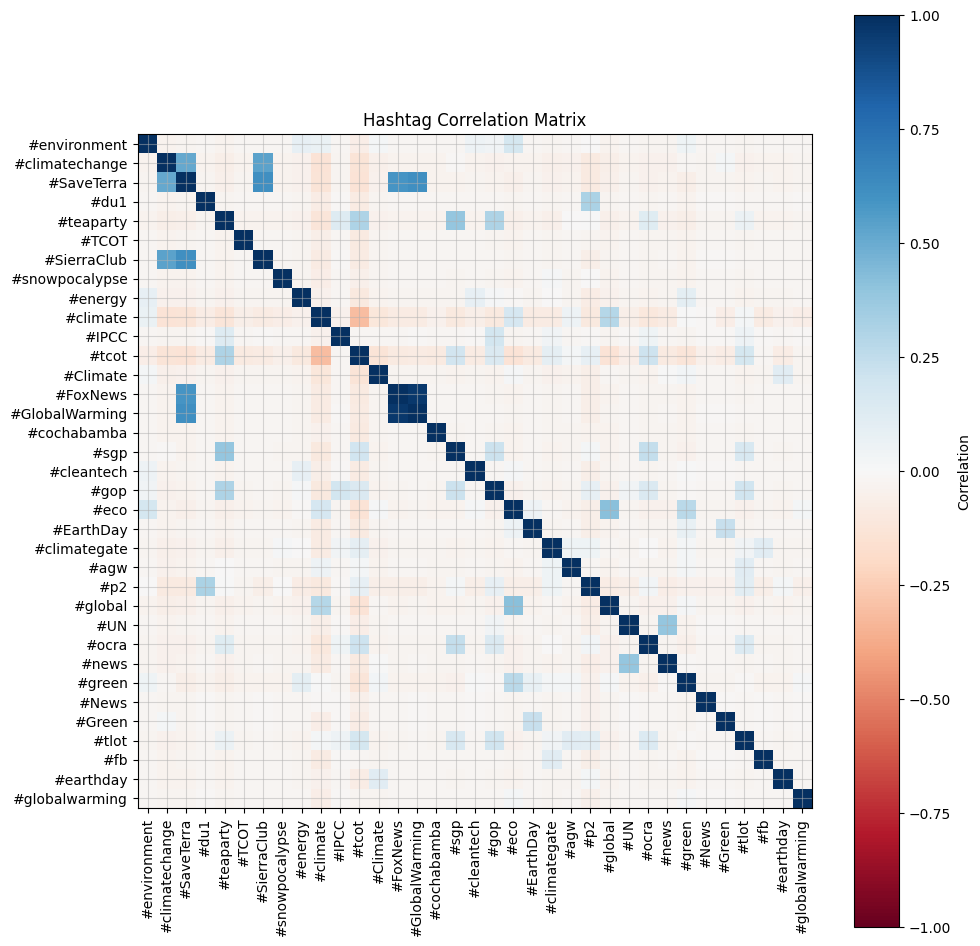

In [81]:
# plot the correlation matrix

plt.figure(figsize=(10,10))
plt.imshow(correlations, cmap='RdBu', vmin=-1, vmax=1, aspect='equal')
plt.colorbar(label='Correlation')
plt.xticks(range(len(correlations)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations)), correlations.index)
plt.title('Hashtag Correlation Matrix')
plt.tight_layout()
plt.grid(alpha = 0.5)
plt.show()

## 3. Text Cleaning for Topic Modeling

### text preprocessing

In [83]:
# remove http links and bitly links

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    return tweet

In [84]:
# remove retweet and @user mentions

def remove_users(tweet):
    tweet = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    tweet = re.sub(r'(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    return tweet

In [85]:
# remove hashtags

def remove_hashtags(tweet):
    tweet = re.sub(r'#\w+', '', tweet)
    return tweet

### text cleaning

NLTK stopwords Size: 179 words Widely used in research: covers function words and common auxiliaries

In [86]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

NLTK does not include large files like stopwords by default, if needed - uncomment and download:

In [88]:
# nltk.download('stopwords')

In [89]:
my_stopwords = list(set(
    stopwords.words('english') + [
        'via', 'make', 'get', 'cause', 'thing',
        'see', 'made', 'say', 'another', 'really', 
        'could', 'think', 'tell', 'know', 'one',
        'doesnt', 'dont', 'isnt', 'like', 'peoples',
    ]
))

In [90]:
stemmer = PorterStemmer(ignore_stopwords = False)

In [91]:
# Clean tweet text
# (optionally add bigrams to the cleaned text)
def clean_tweet(tweet, bigrams=True):
    tweet = remove_users(remove_links(tweet))
    tweet = remove_hashtags(tweet)
    
    # add spaces around the pipe
    tweet = re.sub(r'\s*\|\s*', ' | ', tweet)

    tweet = tweet.lower()

    # remove everything except letters, spaces, and hashtags
    tweet = re.sub(r'[^a-z#\s]', '', tweet)

    # remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    # Tokenize, remove stopwords, and stem
    tokens = [
        word for word in tweet.split(' ')
        if word not in my_stopwords
    ]
    tokens = [
        stemmer.stem(word) if '#' not in word else word
        for word in tokens
    ]

    # Optionally add bigrams
    if bigrams:
        tokens += [
            tokens[i] + '_' + tokens[i + 1]
            for i in range(len(tokens) - 1)
        ]
    return ' '.join(tokens)

In [92]:
# apply cleaning

df['clean_tweet'] = df['tweet'].apply(clean_tweet)

In [93]:
print('Cleaned tweets preview:')
df[['tweet', 'clean_tweet']].head(25)

Cleaned tweets preview:


,tweet,clean_tweet
0,Global warming report urges governments to act...,global warm report urg govern act brussel belg...
1,Fighting poverty and global warming in Africa ...,fight poverti global warm africa fight_poverti...
2,Carbon offsets: How a Vatican forest failed to...,carbon offset vatican forest fail reduc global...
3,Carbon offsets: How a Vatican forest failed to...,carbon offset vatican forest fail reduc global...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,uruguay tool need vulner climat chang uruguay_...
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,ocean salti show global warm intensifi water c...
6,Global warming evidence all around us|A messag...,global warm evid around us messag global warm ...
7,Migratory Birds' New Climate Change Strategy: ...,migratori bird new climat chang strategi stay ...
8,Southern Africa: Competing for Limpopo Water: ...,southern africa compet limpopo water climat ch...
9,"Global warming to impact wheat, rice productio...",global warm impact wheat rice product india lu...


## 4. Vectorization (`Integer Word Counts`) Not TF-IDF

Vectorization (Integer Word Counts) not TF-IDF, because probabilistic LDA model assumes: 
- each document is a distribution over topics,
- each topic is a distribution over words,
- integer word counts are drawn from a multinomial distribution

scikit-learn stopwords Size: 318 words Designed for document vectorization: covers more common informal words

In [94]:
print(ENGLISH_STOP_WORDS)

frozenset({'not', 'amongst', 'one', 'others', 'next', 'itself', 'same', 'full', 'through', 'hasnt', 'has', 'themselves', 'rather', 'cannot', 'how', 'or', 'hence', 'beside', 'fill', 'he', 'towards', 'indeed', 'her', 'his', 'namely', 'wherein', 'a', 'two', 'as', 'him', 'front', 'first', 'to', 'anything', 'whoever', 'un', 'least', 'now', 'sometimes', 'formerly', 'why', 'amoungst', 'noone', 'latterly', 'being', 'three', 'due', 'if', 'had', 'thin', 'whether', 'himself', 'amount', 'nothing', 'further', 'for', 'after', 'off', 'only', 'whereas', 'been', 'keep', 'each', 'wherever', 'therefore', 'thereby', 'sixty', 'but', 'moreover', 'couldnt', 'everywhere', 'fifty', 'although', 'nevertheless', 'without', 'latter', 'once', 'could', 'eleven', 'whereafter', 'she', 'sometime', 'everything', 'detail', 'since', 'find', 'move', 'it', 'nowhere', 'almost', 'still', 'elsewhere', 'thus', 'seem', 'something', 'am', 'besides', 'can', 'describe', 'six', 'so', 'under', 'except', 'than', 'found', 'this', 'most

In [95]:
vectorizer = CountVectorizer(
    min_df = 25,
    max_df = 0.95,
    stop_words = 'english' # built-in stopword list (ENGLISH_STOP_WORDS)
)

In [96]:
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()
tf_feature_names = vectorizer.get_feature_names_out()

In [97]:
print(f'TF matrix shape: {tf.shape}')

TF matrix shape: (6090, 439)


## 5. Apply LDA Topic Modeling

Corpus size alone does not determine the optimal number of topics (k); content diversity and granularity matter mode. \
Therefore: Train models with several topic counts (2 - 25 or more) \
Validate interpretability manually: are topics meaningful and distinct? e.g. k=5 topics are too broad/generic? -> increase k e.g. k=15 topics are overlapping/noisy/duplicative? -> decrease k Choose k that yields the most interpretable, well-separated topics.

In [98]:
# lets assume number of topics

number_of_topics = 10

In [99]:
# set random seed for reproducible results

model = LatentDirichletAllocation(
    n_components = number_of_topics,
    random_state = 1881
)

model.fit(tf)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## 6. Show Top Keywords per topic

In [100]:
# return top words and weights for each topic

def display_topics(model, feature_names, no_top_words=10):
    topic_dict = {}
    for index, topic in enumerate(model.components_):
        topic_dict[f'Topic {index} words'] = [feature_names[i] for i in topic.argsort()[:-no_top_words -1: -1]]
        topic_dict[f'Topic {index} weights'] = [f"{topic[i]:.1f}" for i in topic.argsort()[:-no_top_words -1:-1]]
    return pd.DataFrame(topic_dict)

In [101]:
number_top_words = 10
topics_df = display_topics(model, tf_feature_names, number_top_words)

In [102]:
# LDA transforms raw counts into probabilistic word-topic associations
# output from LDA: weight
# (i.e. how much that word contributes to the topic)

print('Top words per topic:')
topics_df

Top words per topic:


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,586.5,chang,299.6,believ,111.0,global,280.0,global,1621.8,global,402.9,global,807.6,chang,282.2,climat,537.5,climat,1675.1
1,chang,512.3,climat,272.4,save,74.1,warm,266.9,warm,1590.0,warm,402.2,warm,790.4,climat,271.2,chang,532.4,chang,1651.8
2,climat_chang,480.7,climat_chang,251.7,chang,73.2,global_warm,251.8,global_warm,1522.8,global_warm,386.7,global_warm,756.1,climat_chang,228.5,climat_chang,492.0,climat_chang,1520.4
3,energi,179.1,news,184.9,climat_chang,70.4,gore,131.1,snow,252.2,great,93.1,effect,96.5,earth,161.2,new,255.3,legisl,101.1
4,scienc,118.9,senat,112.8,climat,68.9,volcano,129.1,dc,87.3,make,92.4,blame,66.3,world,148.4,fight,122.0,chang_bill,86.7
5,scientist,103.1,impact,87.8,clinic_trial,68.1,al,120.1,law,64.4,blizzard,65.4,help,60.6,day,138.6,report,100.2,talk,70.0
6,polici,64.1,immigr,69.4,chang_clinic,68.1,al_gore,113.1,california,62.6,epa,58.6,air,52.7,confer,104.0,obama,94.2,chang_legisl,63.1
7,debat,59.9,health,62.1,trial,68.1,stop,80.1,caus,57.6,use,51.8,say,48.8,earth_day,69.1,agenc,93.1,graham,56.2
8,green,56.2,carbon,61.0,clinic,68.1,iceland,61.1,storm,57.6,snowstorm,45.8,reduc,46.1,right,69.1,fight_climat,86.1,issu,49.6
9,studi,53.4,mean,59.7,trial_collagen,54.1,want,55.6,new,54.2,wors,44.1,state,45.6,weather,63.9,allergi,74.6,action,46.2


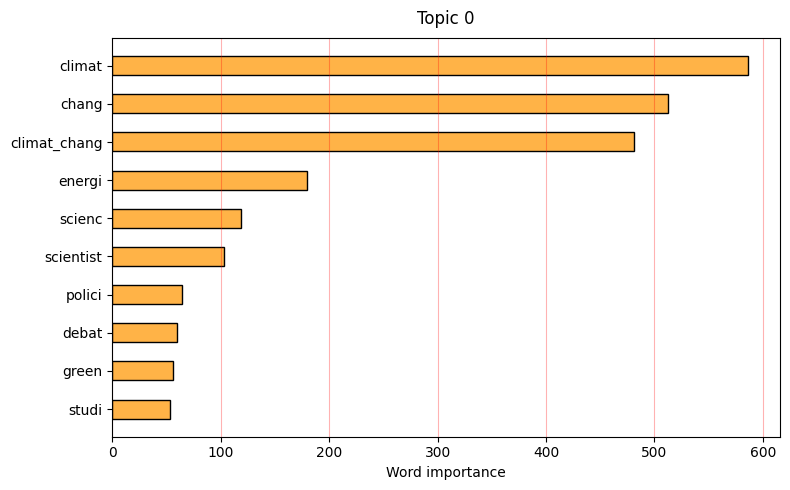

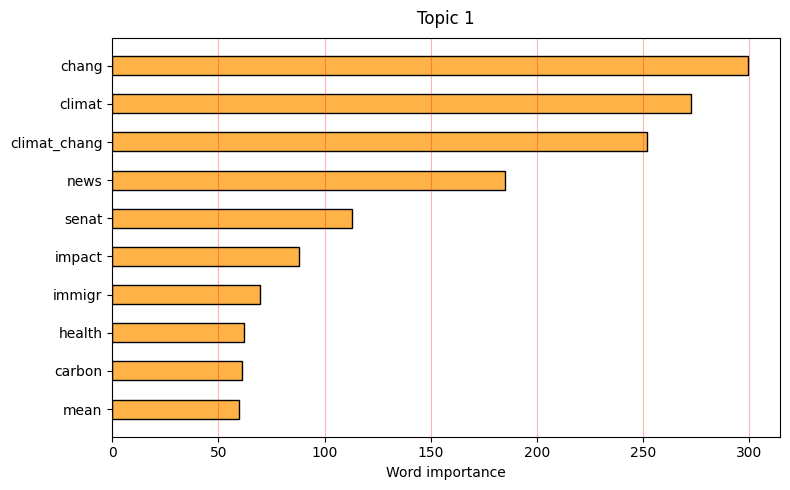

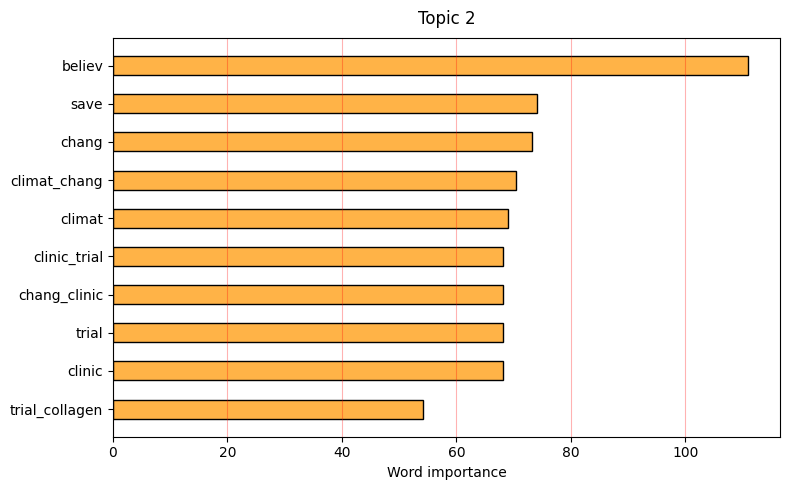

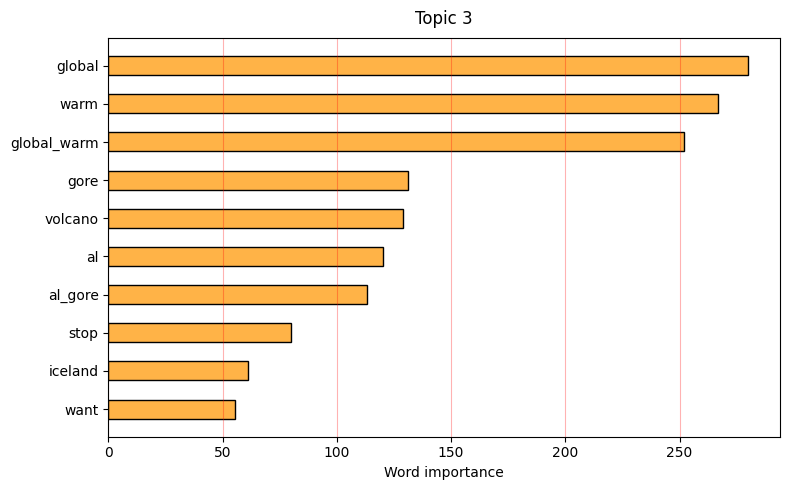

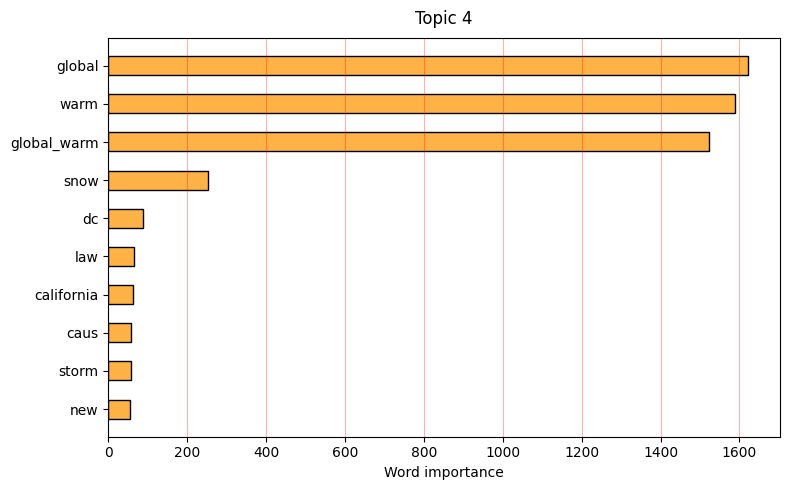

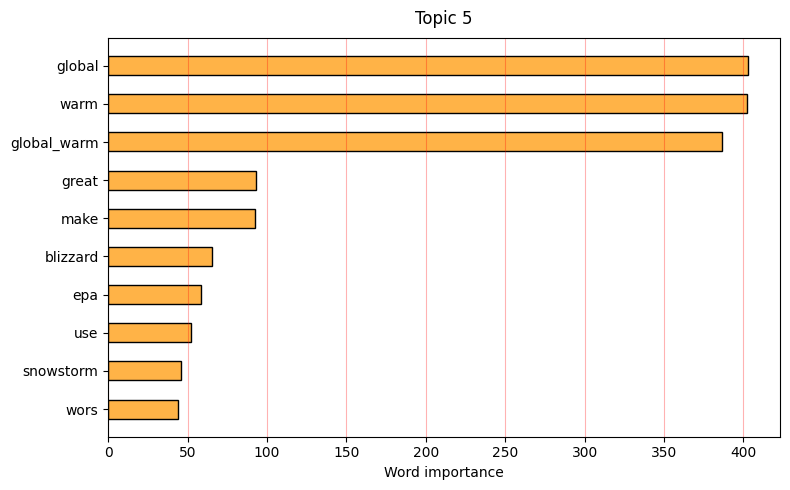

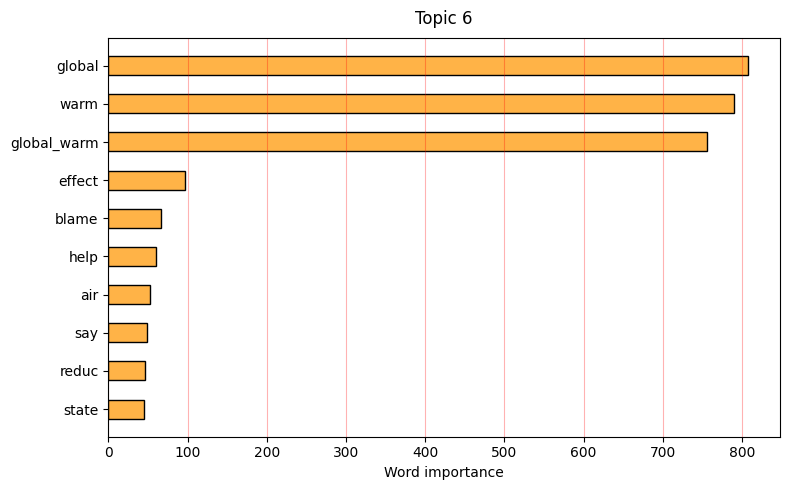

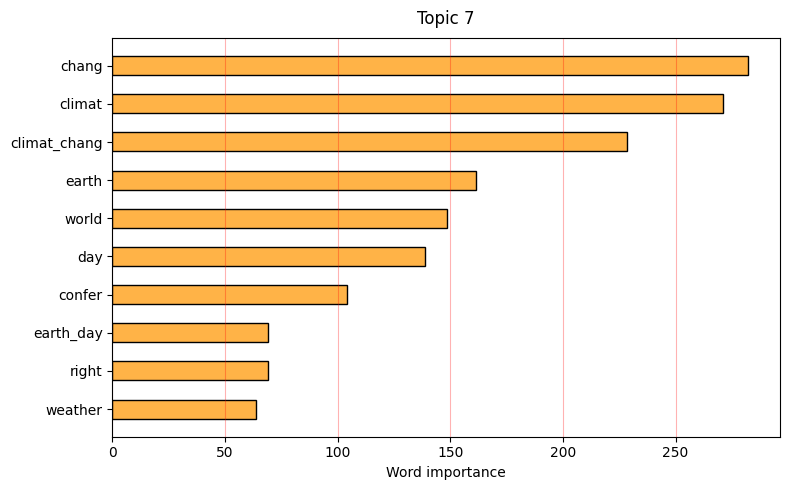

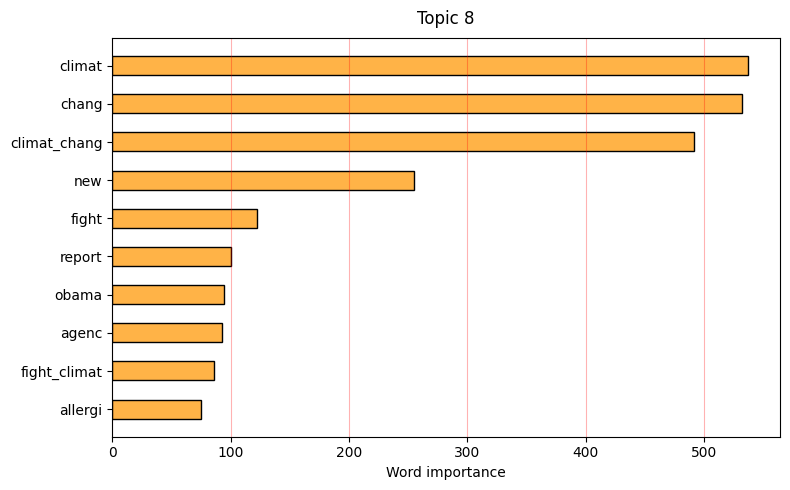

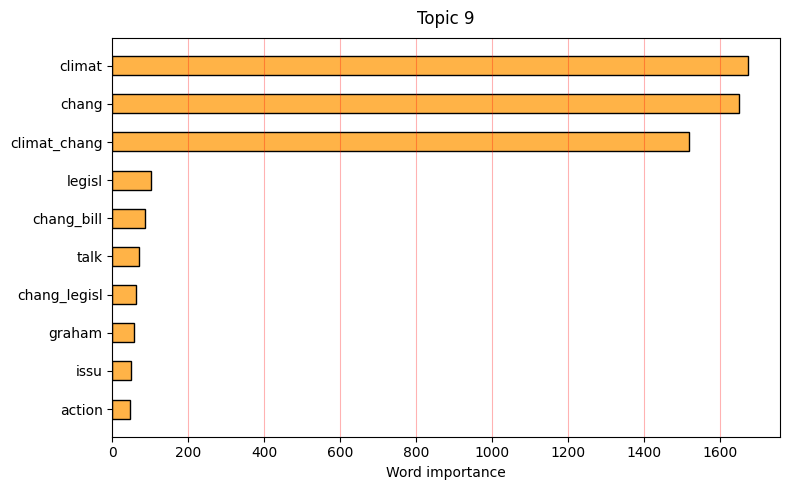

In [105]:
for i, topic in enumerate(model.components_):
    top = topic.argsort()[-10:]
    words = [tf_feature_names[j] for j in top][::-1]
    weights = topic[top][::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(words, weights, color='#FFB347', height=0.5, edgecolor='black', alpha=1.0)
    plt.gca().invert_yaxis()
    plt.xlabel('Word importance')
    plt.title(f'Topic {i}', pad = 10)
    plt.grid(alpha=0.3, axis='x', color = 'red')
    plt.tight_layout()
    plt.show()

## 8. Additional: `STEM` Completion for Text Cleaning

Repeat ALL steps 3-7 covering frequency-based stem completion:

1. Build the dictionary `stem_to_word` before cleaning
2. Define a function `stem_completion()`
3. Inside clean_tweet(), after stemming, call stem_completion()

In [107]:
# 1) Build the dictionary stem_to_word before cleaning:

from collections import Counter

In [108]:
# combines all tweets into one string, lowercases everything, splits on spaces
# Counter() counts how many times each word appears.

word_freq = Counter(' '.join(df['tweet']).lower().split())

In [109]:
# initialize an empty dictionary

stem_to_word = {}

In [110]:
# loop over every word in corpus and decide:
# if this is the first word seen with this stem -> store it.
# if already stored a word for this stem -> replace it only if ...
# ...the new word occurs more oftern.

for word in word_freq:
    stem = stemmer.stem(word)
    if stem not in stem_to_word or word_freq[word] > word_freq[stem_to_word[stem]]:
        stem_to_word[stem] = word

In [111]:
# 2) Define a function stem_completion():

def stem_completion(word, stem_to_word):
    return stem_to_word.get(word, word)

# returns the most frequent (completed) word if the stem exists in the dictionary
# (otherwise, it just returns the original word unchanged)

In [112]:
# 3) inside clean_tweet(), after stemming, call stem_completion() 

def clean_tweet(tweet, bigrams=True):
    tweet = remove_users(remove_links(tweet))
    tweet = remove_hashtags(tweet)
    
    # add spaces around the pipe
    tweet = re.sub(r'\s*\|\s*', ' | ', tweet)

    tweet = tweet.lower()

    # remove everything except letters, spaces, and hashtags
    tweet = re.sub(r'[^a-z#\s]', '', tweet)

    # remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    # Tokenize, remove stopwords, and stem
    tokens = [
        word for word in tweet.split(' ')
        if word not in my_stopwords
    ]
    tokens = [
        stemmer.stem(word) if '#' not in word else word
        for word in tokens
    ]

    # Frequency-based stem completion
    tokens = [stem_completion(word, stem_to_word) for word in tokens]

    # Optionally add bigrams
    if bigrams:
        tokens += [
            tokens[i] + '_' + tokens[i + 1]
            for i in range(len(tokens) - 1)
        ]
    return ' '.join(tokens)

In [114]:
df['clean_tweet'] = df['tweet'].apply(clean_tweet)

In [115]:
print('Cleaned tweets preview:')
df[['tweet', 'clean_tweet']].head(25)

Cleaned tweets preview:


,tweet,clean_tweet
0,Global warming report urges governments to act...,global warming report urges government act bru...
1,Fighting poverty and global warming in Africa ...,fight poverty global warming africa fight_pove...
2,Carbon offsets: How a Vatican forest failed to...,carbon offsets vatican forests failed reduce g...
3,Carbon offsets: How a Vatican forest failed to...,carbon offsets vatican forests failed reduce g...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,uruguay tools need vulnerable climate change u...
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,ocean saltiness shows global warming intensify...
6,Global warming evidence all around us|A messag...,global warming evidence around us message glob...
7,Migratory Birds' New Climate Change Strategy: ...,migratory birds new climate change strategy st...
8,Southern Africa: Competing for Limpopo Water: ...,southern africa competing limpopo water climat...
9,"Global warming to impact wheat, rice productio...",global warming impacts wheat rice production i...


### Vectorization (`Integer Word Counts`)

In [116]:
vectorizer = CountVectorizer(
    min_df = 25, 
    max_df = 0.95,
    stop_words = 'english' # built-in stopword list (ENGLISH_STOP_WORDS)
)

In [117]:
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()
tf_feature_names = vectorizer.get_feature_names_out()

In [119]:
print(f'TF matrix shape: {tf.shape}')

TF matrix shape: (6090, 440)


### Apply LDA Topic Modeling

In [120]:
number_of_topics = 10

In [122]:
model = LatentDirichletAllocation(
    n_components = number_of_topics, 
    random_state = 1881
)

model.fit(tf)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


### Show Top Keywords per topic

In [123]:
number_top_words = 10
topics_df = display_topics(model, tf_feature_names, number_top_words)

In [124]:
print('Top words per topic:')
topics_df

Top words per topic:


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,change,528.4,change,190.3,climate,538.8,climate,1520.8,climate,164.6,global,423.8,global,645.6,global,425.4,climate,490.0,global,1617.6
1,climate,517.0,energy,157.9,change,514.5,change,1477.5,change,159.3,warming,413.6,warming,644.7,warming,414.2,change,481.7,warming,1574.5
2,climate_change,477.6,climate,143.6,climate_change,475.8,climate_change,1379.3,climate_change,145.9,global_warming,393.3,global_warming,602.6,global_warming,403.3,climate_change,435.1,global_warming,1518.2
3,fight,107.8,climate_change,129.9,change_bill,114.1,science,94.7,world,136.2,snow,193.2,scientists,117.9,effects,100.1,new,157.5,snow,83.0
4,fight_climate,86.1,carbon,95.1,legislation,106.1,new,75.4,conference,110.1,gore,131.1,causes,88.1,law,96.9,report,142.9,dc,78.6
5,issues,72.9,environmental,73.1,graham,90.1,news,64.6,believe,90.4,al,120.1,debate,64.8,california,87.1,agency,93.1,great,74.1
6,clinical,68.1,forests,53.1,senate,78.0,india,64.1,rights,69.1,al_gore,113.1,winter,58.4,using,58.4,obama,87.5,day,71.0
7,change_clinical,68.1,groups,46.9,talks,77.7,green,63.8,conference_climate,55.1,dc,80.7,science,55.6,globalwarming,47.1,blizzards,74.2,air,66.6
8,trials,68.1,reduce,46.1,puts,74.7,earth,58.5,live,52.7,weather,74.7,volcano,45.2,plants,43.4,make,70.7,blame,66.1
9,clinical_trials,68.1,support,37.4,change_legislation,63.1,panel,58.1,believe_global,51.1,storms,68.5,cool,44.1,increase,39.4,federal,67.1,new,61.2


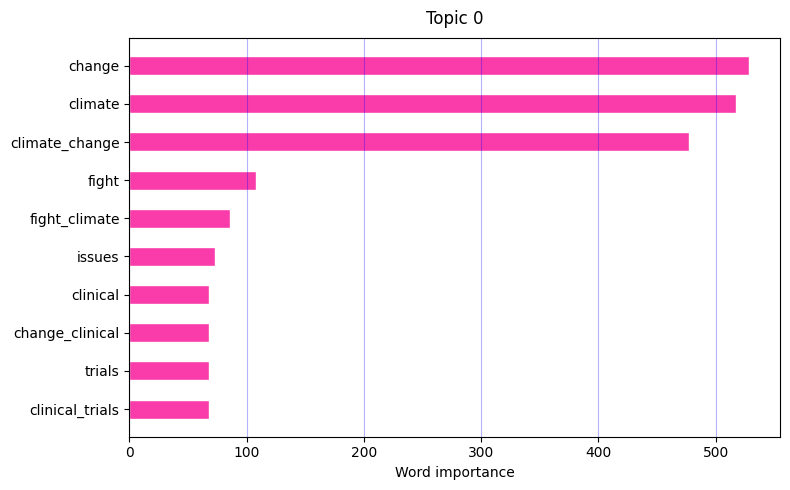

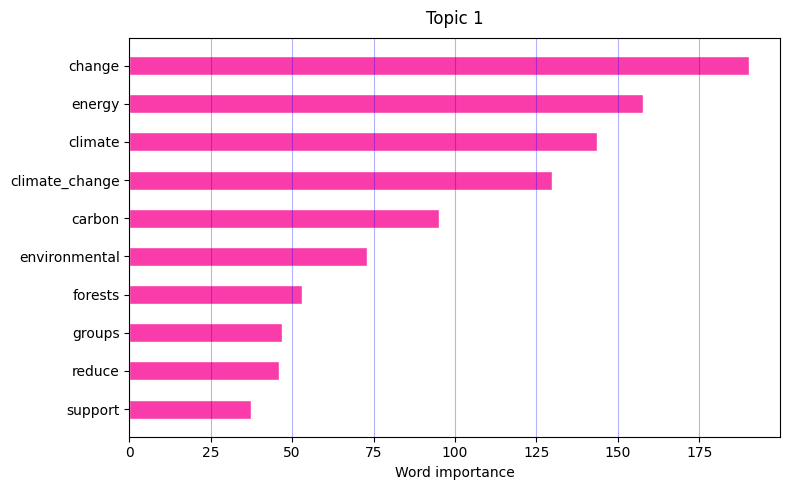

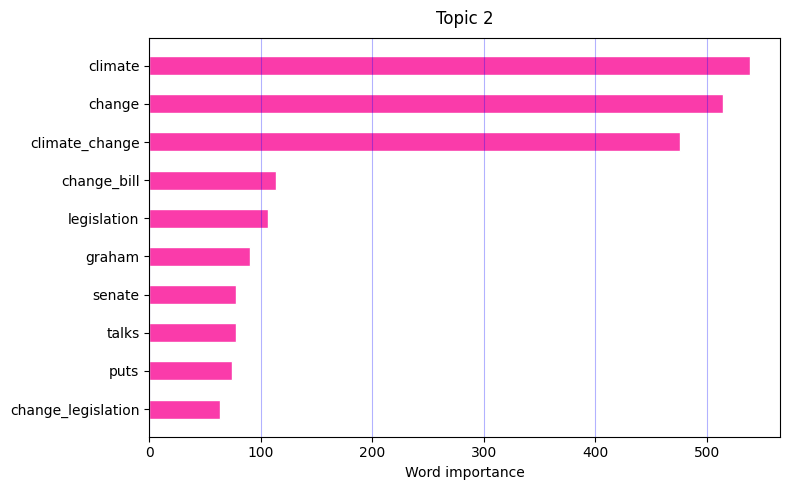

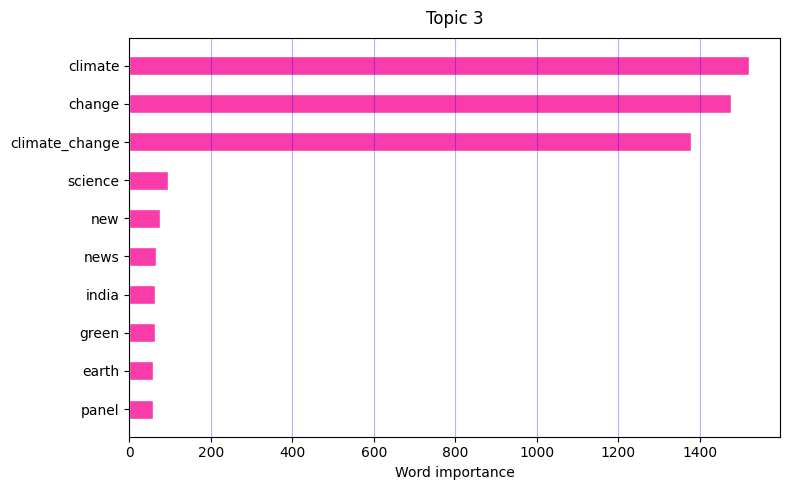

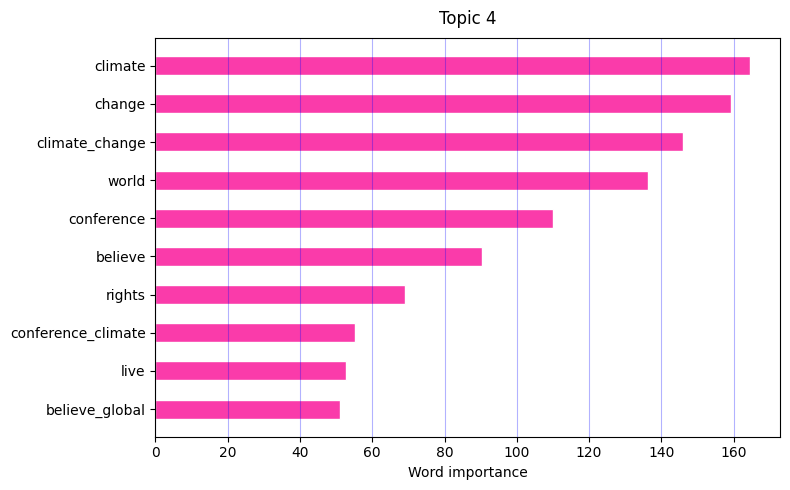

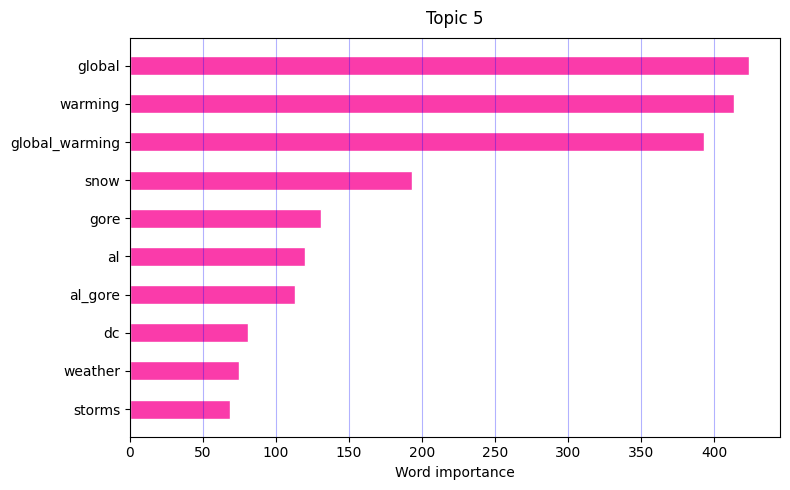

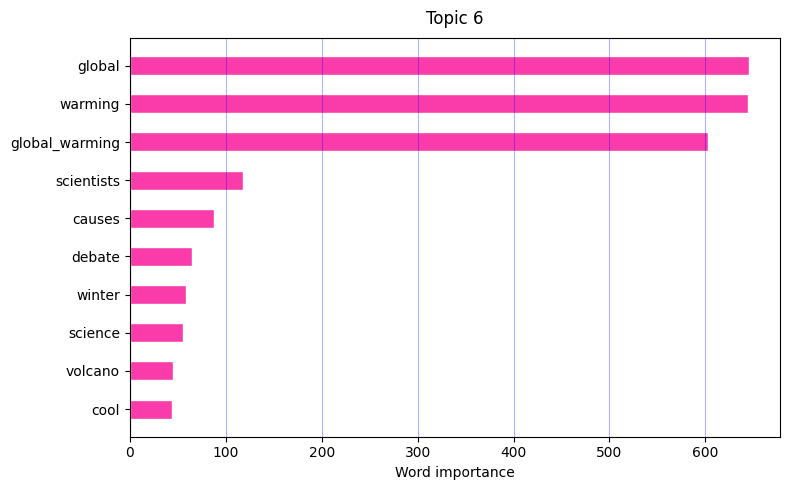

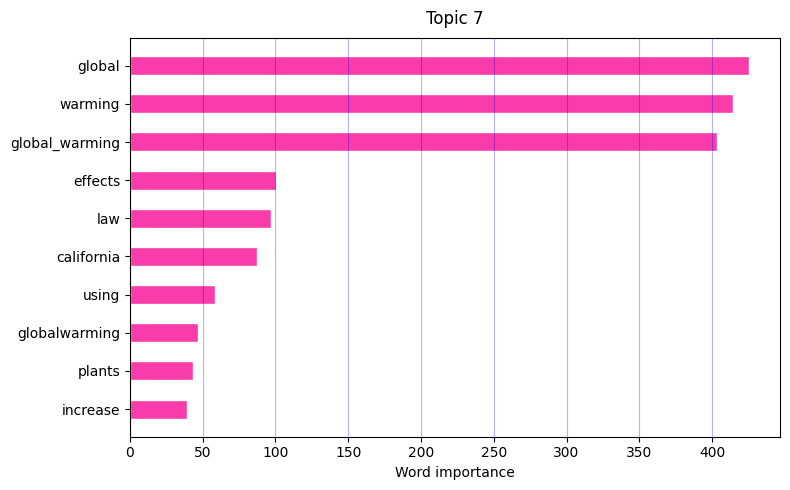

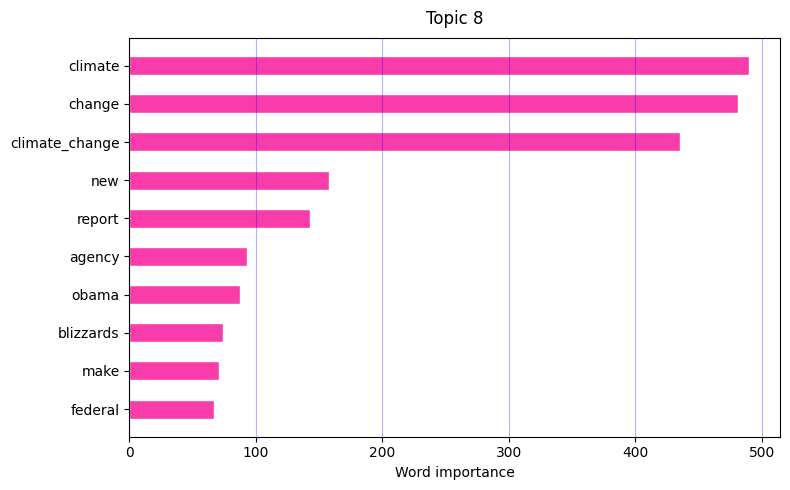

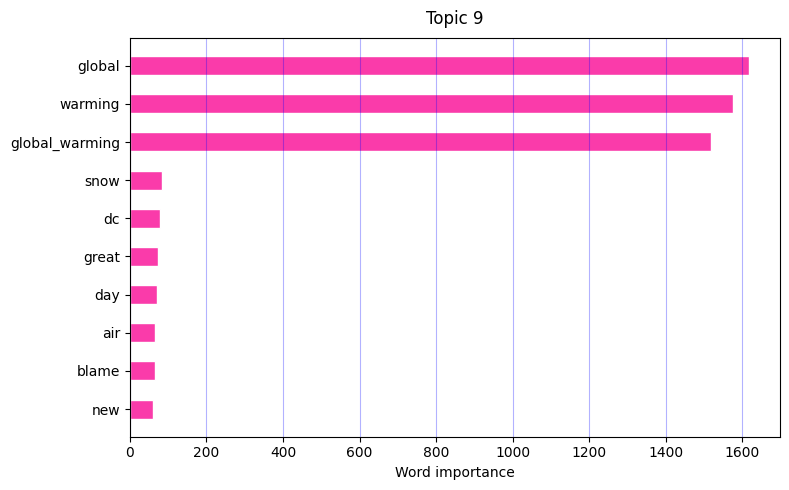

In [129]:
for i, topic in enumerate(model.components_):
    top = topic.argsort()[-10:]
    words = [tf_feature_names[j] for j in top][::-1]
    weights = topic[top][::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(words, weights, color='#fa3baa', height=0.5, edgecolor='white')
    plt.gca().invert_yaxis()
    plt.xlabel("Word importance")
    plt.title(f"Topic {i}", pad=10)
    plt.grid(alpha=0.3, axis='x', color='blue')
    plt.tight_layout()
    plt.show()

# Topic Modeling 2

### Topic Modeling of Amazon Reviews

Amazon_Reviews_small.csv

Column of Focus: Text: raw review text

##########################################################
Steps:
1. Load, preprocess and clean data
2. Vectorize text (integer word counts, not TF-IDF)
3. Apply LDA topic modeling
4. Explore topics
5. Visualization of topic modeling
6. Assign dominant topic to each review

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### 1. Load the Data and Preprocess

In [2]:
reviews = pd.read_csv('Data/Amazon_Reviews_small.csv')

In [3]:
# rename the column for clarity and clean text reviews

if 'Text;;' in reviews.columns:
    reviews = reviews.rename(columns={'Text;;': 'Text'})

In [5]:
# remove any ';;' artifacts from the text, 
# and strip redundand whitespaces

reviews['Text'] = reviews['Text'].str.replace(';;', '', regex = False).str.strip()

In [6]:
# drop any rows with missing text
# (as CountVectorizer cannot handle NaN)

reviews = reviews.dropna(subset=['Text'])

In [18]:
print(f'Dataset shape: {reviews.shape}')
print('Sample review text:')
print(reviews['Text'].iloc[10])

Dataset shape: (93, 10)
Sample review text:
I have McCann's Oatmeal every morning and by ordering it from Amazon I am able to save almost $3.00 per box.<br />It is a great product. Tastes great and very healthy


### Text Cleaning for Topic Modeling

In [32]:
# remove HTML tags like <br>, <br/>, <br />, etc.
# (with optional slash and spaces)

def remove_html_tags(text):
    text = re.sub(r'<\s*br\s*/?\s*>', ' ', text, flags = re.IGNORECASE)
    # then remove any other HTML tags just in case
    text = re.sub(r'<.*?>', ' ', text)
    return text

### Build STEM-TO-WORD Dictionary (for stem completion)

In [21]:
# combine all reviews into one string

word_freq = Counter(" ".join(reviews['Text']).lower().split())

In [25]:
# word_freq

In [26]:
# define stopwords and stemmer

my_stopwords = stopwords.words('english')
stemmer = PorterStemmer(ignore_stopwords=False)

In [27]:
stem_to_word = {}
for word in word_freq:
    stem = stemmer.stem(word)
    # store the most frequent word for each stem
    if stem not in stem_to_word or word_freq[word] > word_freq[stem_to_word[stem]]:
        stem_to_word[stem] = word

In [28]:
# return the most frequent (completed) word for a given stem

def stem_completion(word, stem_to_word):
    return stem_to_word.get(word, word)

In [29]:
# define stopwords and stemmer

my_stopwords = stopwords.words('english')
stemmer = PorterStemmer(ignore_stopwords = False)

In [30]:
# cleaning function

def clean_review(text):
    text = remove_html_tags(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text) # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize, remove stopwords, stem, and complete stems
    tokens = [word for word in text.split() if word not in my_stopwords]
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [stem_completion(word, stem_to_word) for word in tokens]
    return ' '.join(tokens)

In [33]:
# apply cleaning

reviews['clean_text'] = reviews['Text'].apply(clean_review)

In [36]:
print('Cleaned review text preview:')
reviews[['Text', 'clean_text']].head(10)

Cleaned review text preview:


,Text,clean_text
0,I have bought several of the Vitality canned d...,bought several vitality can dog food product f...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
8,Right now I'm mostly just sprouting this so my...,right mostly sprouting cats eat grass love rot...
9,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
16,I love eating them and they are good for watch...,love eat good watching tv looking movi sweet l...
17,I am very satisfied with my Twizzler purchase....,satisfied twizzler purchased shared other enjo...
19,Candy was delivered very fast and was purchase...,candy delivered fast purchased reasonable pric...
22,I can remember buying this candy as a kid and ...,remember buy candy kid quality dropped year st...
23,I love this candy. After weight watchers I ha...,love candy weight watchers cut back still craving
27,I was so glad Amazon carried these batteries. ...,glad amazon carried batteri hard time find els...


## 2. Vectorization (Integer Word Counts)
We use raw counts (not TF-IDF) because probabilistic LDA model assumes:
- each document is a distribution over topics,
- each topic is a distribution over words,
- integer word counts are drawn from a multinomial distribution.

In [37]:
# keep words appearing in at least 2 reviews
# ignore very frequent words (>95% of docs)

vectorizer = CountVectorizer(
    min_df = 2,
    max_df = 0.95,
    stop_words = 'english' # built-in stopword list (ENGLISH_STOP_WORDS)
)

In [38]:
# Transform text data into DTM

DTM = vectorizer.fit_transform(reviews['clean_text'].values.astype('U'))

In [39]:
print(f'Document-Term Matrix shape: {DTM.shape}')
print(f'Vocabulary size: {len(vectorizer.get_feature_names_out())} words')

Document-Term Matrix shape: (93, 212)
Vocabulary size: 212 words


## 3. Apply LDA Topic Modeling

In [40]:
number_of_topics = 5

In [41]:
lda_model = LatentDirichletAllocation(
    n_components = number_of_topics,
    random_state = 1881
)

In [42]:
lda_model.fit(DTM)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## 4. Explore Topics

In [45]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['able', 'add', 'added', 'addition', 'allergi', 'allergic',
       'alternative', 'amazon', 'apple', 'arrived', 'ate', 'available',
       'awesom', 'bad', 'bag', 'balance', 'base', 'believe', 'best',
       'better', 'big', 'book', 'bottle', 'bought', 'box', 'brand',
       'bucks', 'bulk', 'buy', 'came', 'candy', 'carried', 'cats',
       'cheaper', 'chicken', 'chips', 'christmas', 'cinnamon', 'clean',
       'coffee', 'come', 'compared', 'convenience', 'cook', 'cookies',
       'cut', 'days', 'deal', 'definitely', 'delicious', 'delivered',
       'different', 'digestion', 'dog', 'door', 'drink', 'dry', 'easy',
       'eat', 'enjoyed', 'exactly', 'excellent', 'extremely', 'family',
       'fantastic', 'far', 'fast', 'favorably', 'favorite', 'feeding',
       'feeling', 'filling', 'flavor', 'food', 'free', 'fresh', 'friends',
       'glad', 'goes', 'good', 'got', 'great', 'green', 'grocery',
       'growing', 'ham', 'hand', 'hard', 'healthy', 'helps', 'highly',
       'hit', 'ho

In [48]:
# find top 10 words for the first topic

print('Top 10 words in Topic 0:')
print([feature_names[i] for i in lda_model.components_[0].argsort()[-10:][::-1]])

Top 10 words in Topic 0:
['product', 'taste', 'used', 'like', 'drink', 'good', 'tea', 'buy', 'year', 'love']


In [49]:
# Find top 10 words for all topics
for i, topic in enumerate(lda_model.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-10:][::-1]]
    print(f"Topic #{i}: {top_words}\n")

Topic #0: ['product', 'taste', 'used', 'like', 'drink', 'good', 'tea', 'buy', 'year', 'love']

Topic #1: ['chips', 'salt', 'flavor', 'free', 'healthy', 'good', 'taste', 'favorite', 'brand', 'bag']

Topic #2: ['really', 'great', 'like', 'store', 'flavor', 'taste', 'buy', 'amazon', 'sugar', 'easy']

Topic #3: ['good', 'eat', 'best', 'love', 'flavor', 'time', 'food', 'try', 'cats', 'price']

Topic #4: ['food', 'dog', 'love', 'great', 'natural', 'used', 'balance', 'favorite', 'dry', 'different']



## 5. Visualization of Topic Modeling

In [50]:
# --- (A) BAR PLOT: Number of reviews per topic

topic_values = lda_model.transform(DTM)
dominant_topics = topic_values.argmax(axis=1)

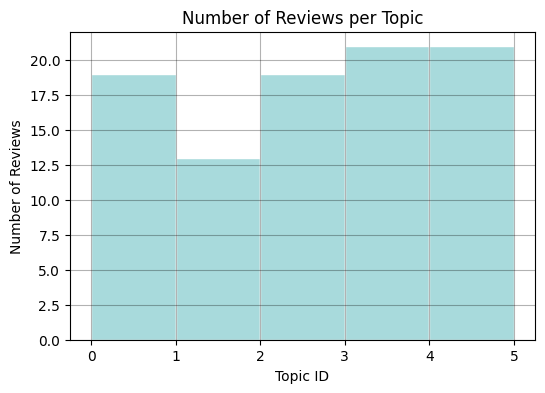

In [51]:
plt.figure(figsize=(6,4))
plt.hist(dominant_topics, bins=range(number_of_topics + 1), color='#A8DADC', edgecolor='white')
plt.title("Number of Reviews per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.3, color = 'black')
plt.show()

In [52]:
# (B) WORD CLOUDS: Keywords for each topic ---

feature_names = vectorizer.get_feature_names_out()

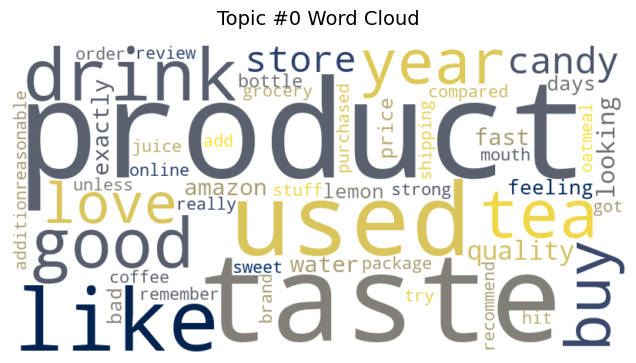

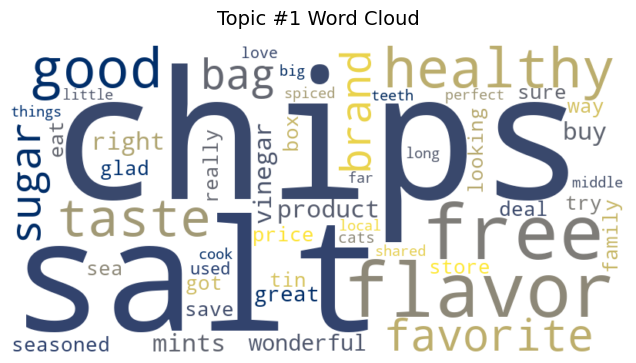

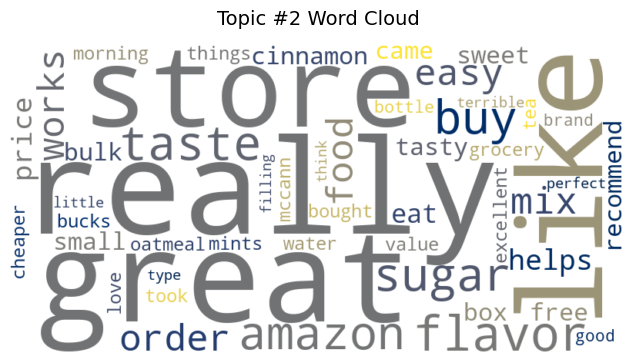

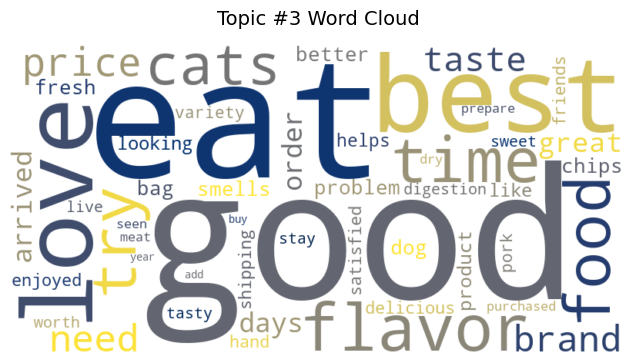

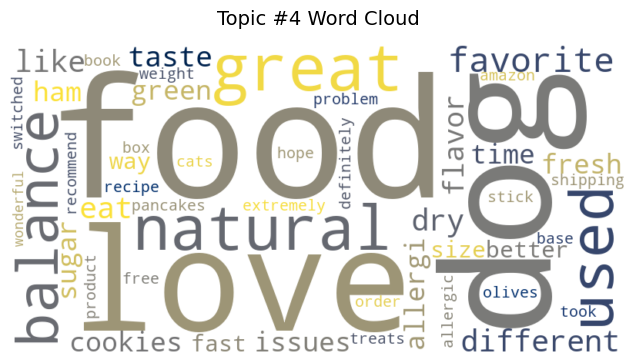

In [53]:
for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[-50:]}  # top 50 words per topic
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='cividis'
    ).generate_from_frequencies(topic_words)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{topic_idx} Word Cloud", fontsize=14, pad=15)
    plt.show()

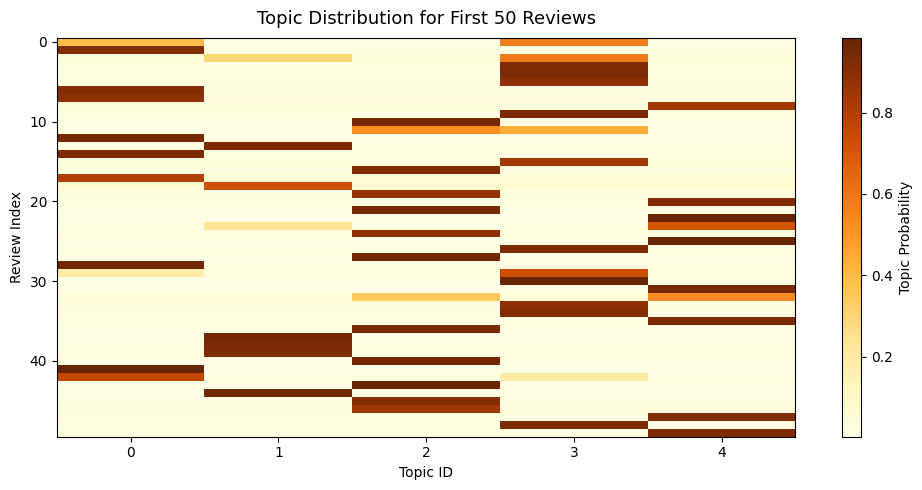

In [54]:
# --- (C) HEATMAP: Document-topic distribution ---

plt.figure(figsize=(10, 5))
plt.imshow(topic_values[:50], aspect='auto', cmap='YlOrBr')
plt.colorbar(label='Topic Probability')
plt.title("Topic Distribution for First 50 Reviews", fontsize=13, pad=10)
plt.xlabel("Topic ID")
plt.ylabel("Review Index")
plt.xticks(range(number_of_topics))
plt.tight_layout()
plt.show()

## 6. Assign Dominant Topic to each review

In [55]:
# Assign each review's dominant topic
reviews['Topic'] = dominant_topics

In [56]:
# Show topic distribution
print("Topic distribution (number of reviews per topic):")
print(reviews['Topic'].value_counts().sort_index(), "\n")

Topic distribution (number of reviews per topic):
Topic
0    19
1    13
2    19
3    21
4    21
Name: count, dtype: int64 



In [57]:
# Extract representative keywords per topic
topic_keywords = []
for i, topic in enumerate(lda_model.components_):
    words = [feature_names[j] for j in topic.argsort()[-5:][::-1]]
    topic_keywords.append(", ".join(words))

In [59]:
# Show sample reviews for each topic
for i, kw in enumerate(topic_keywords):
    print(f"Topic {i}: {kw}")
    examples = reviews.loc[reviews['Topic'] == i, 'Text'].head(2)
    for text in examples:
        print(f"  • {text[:150]}{'...' if len(text) > 150 else ''}")
    print()

Topic 0: product, taste, used, like, drink
  • If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (whic...
  • Candy was delivered very fast and was purchased at a reasonable price.  I was home bound and unable to get to a store so this was perfect for me.

Topic 1: chips, salt, flavor, free, healthy
  • This is the same stuff you can buy at the big box stores.  There is nothing healthy about it.  It is just carbs and sugars.  Save your money and get s...
  • It is okay.  I would not go out of my way to buy it again

Topic 2: really, great, like, store, flavor
  • I have McCann's Oatmeal every morning and by ordering it from Amazon I am able to save almost $3.00 per box.<br />It is a great product. Tastes great ...
  • We really like the McCann's steel cut oats but find we don't cook it up too often.<br />This tastes much better to me than the grocery store brands an...

Topic 3: good, eat, be

# Topic Modeling 3

### Topic Modeling of Amazon Reviews with non-negative matrix factorization

Amazon_Reviews_small.csv

Column of focus: Text: raw review text

Steps:

1. Load, preprocess and clean data
2. Vectorize text (TF-IDF for NMF)
3. Apply LDA topic modeling
4. Explore topics
5. Visualization of topic modeling
6. Assign dominant topic to each review

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer # vs CountVectorizer
from sklearn.decomposition import NMF # Non-Negative Matrix Factorization
from wordcloud import WordCloud

### 1. Load the Data and Preprocess

In [64]:
reviews = pd.read_csv('Data/Amazon_Reviews_small.csv')

reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text;;
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,"2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,13469...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    object
 1   ProductId               106 non-null    object
 2   UserId                  100 non-null    object
 3   ProfileName             99 non-null     object
 4   HelpfulnessNumerator    96 non-null     object
 5   HelpfulnessDenominator  96 non-null     object
 6   Score                   95 non-null     object
 7   Time                    94 non-null     object
 8   Summary                 93 non-null     object
 9   Text;;                  93 non-null     object
dtypes: object(10)
memory usage: 39.2+ KB


In [66]:
# Rename the column for clarity and clean text reviews

if 'Text;;' in reviews.columns:
    reviews = reviews.rename(columns={'Text;;': 'Text'})

In [67]:
# Remove any ';;' artifacts from the text, 
# and strip redundand whitespaces

reviews['Text'] = reviews['Text'].str.replace(';;', '', regex=False).str.strip()

In [69]:
# Drop any rows with missing text
# (as vectorizer cannot handle NaN)

reviews = reviews.dropna(subset = ['Text'])

In [70]:
print(f"Dataset shape: {reviews.shape}")
print("Sample review text:")
print(reviews['Text'].iloc[10])

Dataset shape: (93, 10)
Sample review text:
I have McCann's Oatmeal every morning and by ordering it from Amazon I am able to save almost $3.00 per box.<br />It is a great product. Tastes great and very healthy


### Text Cleaning

In [71]:
# cleaning function

def clean_review(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)          # remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)        # remove punctuation
    text = re.sub(r'\d+', ' ', text)            # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()    # remove spaces
    return text

In [72]:
# apply cleaning

reviews['clean_text'] = reviews['Text'].apply(clean_review)

In [73]:
print('Cleaned review text preview:')
reviews[['Text', 'clean_text']].head(10)

Cleaned review text preview:


,Text,clean_text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
8,Right now I'm mostly just sprouting this so my...,right now i m mostly just sprouting this so my...
9,This is a very healthy dog food. Good for thei...,this is a very healthy dog food good for their...
16,I love eating them and they are good for watch...,i love eating them and they are good for watch...
17,I am very satisfied with my Twizzler purchase....,i am very satisfied with my twizzler purchase ...
19,Candy was delivered very fast and was purchase...,candy was delivered very fast and was purchase...
22,I can remember buying this candy as a kid and ...,i can remember buying this candy as a kid and ...
23,I love this candy. After weight watchers I ha...,i love this candy after weight watchers i had ...
27,I was so glad Amazon carried these batteries. ...,i was so glad amazon carried these batteries i...


### 2. Vectorization (TF-IDF)

NMF works best with TF-IDF, not raw counts (CountVectorizer)

In [74]:
# keep words appearing in at least 2 reviews
# ignore very frequent words (>95% of docs)

vectorizer = TfidfVectorizer(
    min_df = 2,
    max_df = 0.95,
    stop_words = 'english' # built-in stopword list (ENGLISH_STOP_WORDS)
)

In [75]:
# Transform text data into DTM (Document-Term Matrix)

DTM_TFIDF = vectorizer.fit_transform(reviews['clean_text'].values.astype('U'))
feature_names = vectorizer.get_feature_names_out()

In [76]:
print(f"Document-Term Matrix shape: {DTM_TFIDF.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())} words")

Document-Term Matrix shape: (93, 229)
Vocabulary size: 229 words


### 3. Apply NMF (non-negative matrix factorization) Topic Modeling

In [77]:
number_of_topics = 5
n_top_words = 10

In [78]:
nmf_model = NMF(
    n_components = number_of_topics,
    random_state = 1881
)

In [79]:
nmf_model.fit(DTM_TFIDF) # DTM_TFIDF - vectorized text 

,n_components,5
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,1881
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


### 4. Explore Topics

In [80]:
# Find top 10 words for all topics

def display_topics(model, feature_names, n_top_words=10):
    for i, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        print(f'Topic {i}: {', '.join(top_words)}')

In [81]:
print('Top words per topic:')
display_topics(nmf_model, feature_names, n_top_words)

Top words per topic:
Topic 0: taste, like, just, tea, loved, bottle, easy, don, fantastic, fresh
Topic 1: food, dog, balance, natural, different, dry, better, good, cat, feeding
Topic 2: store, product, price, candy, arrived, local, grocery, buying, quality, delivered
Topic 3: chips, flavor, best, good, bag, favorite, tried, vinegar, salt, potato
Topic 4: great, amazon, sugar, buy, likes, free, cheaper, order, really, mints


### 5. Visualization of Topic Modeling

In [82]:
# --- (A) BAR PLOT: Number of reviews per topic ---

topic_values = nmf_model.transform(DTM_TFIDF)
dominant_topics = topic_values.argmax(axis=1)

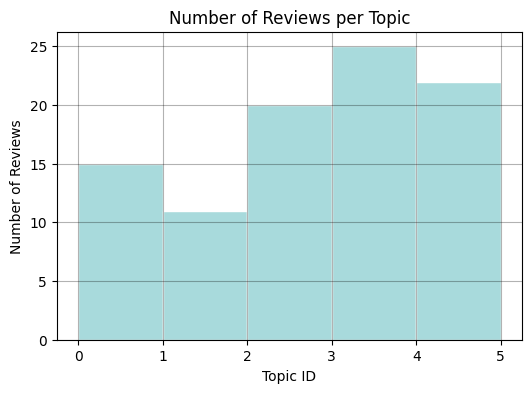

In [83]:
plt.figure(figsize=(6,4))
plt.hist(dominant_topics, bins=range(number_of_topics + 1), color='#A8DADC', edgecolor='white')
plt.title("Number of Reviews per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.3, color='black')
plt.show()

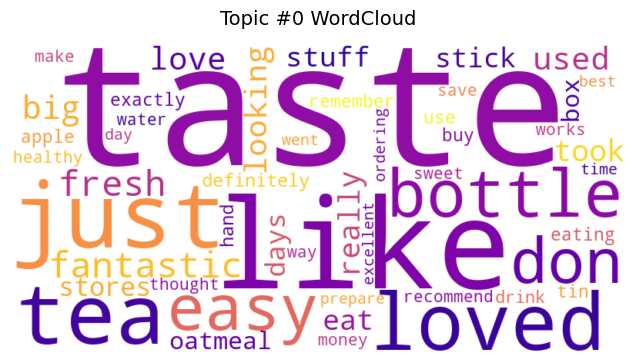

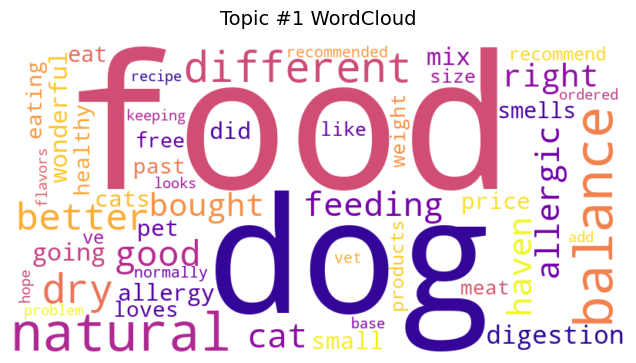

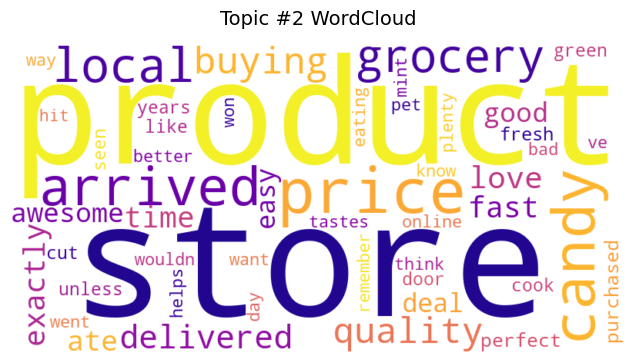

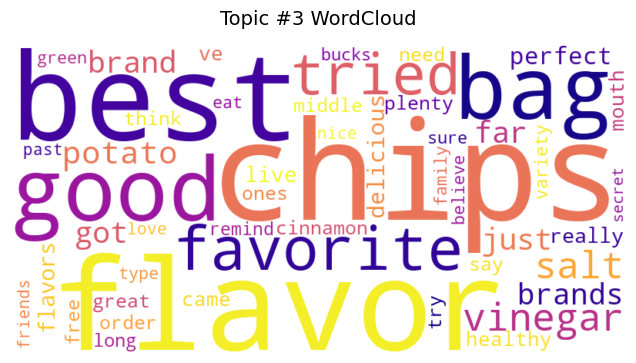

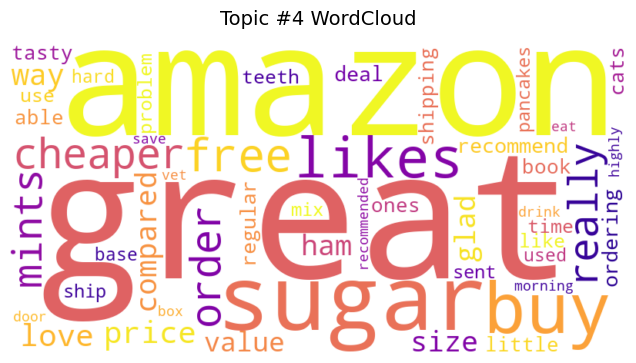

In [86]:
# --- (B) WORD CLOUDS: Keywords for each topic ---

for i, topic in enumerate(nmf_model.components_):
    topic_words = {feature_names[j]: topic[j] for j in topic.argsort()[-50:]}
    wc = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='plasma'
    ).generate_from_frequencies(topic_words)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{i} WordCloud", fontsize=14, pad=15)
    plt.show()

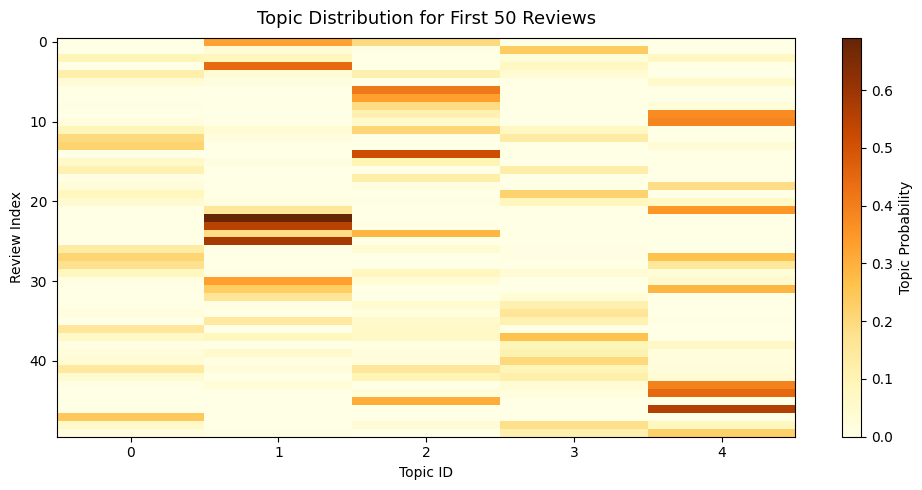

In [87]:
# --- (C) HEATMAP: Document-topic distribution ---

plt.figure(figsize=(10, 5))
plt.imshow(topic_values[:50], aspect='auto', cmap='YlOrBr')
plt.colorbar(label='Topic Probability')
plt.title("Topic Distribution for First 50 Reviews", fontsize=13, pad=10)
plt.xlabel("Topic ID")
plt.ylabel("Review Index")
plt.xticks(range(number_of_topics))
plt.tight_layout()
plt.show()

### 6. Assign Dominant Topic to each Review

In [88]:
# Assign each review's dominant topic

reviews['Topic'] = dominant_topics

In [89]:
# Show topic distribution
print("Topic distribution (number of reviews per topic):")
print(reviews['Topic'].value_counts().sort_index())

Topic distribution (number of reviews per topic):
Topic
0    15
1    11
2    20
3    25
4    22
Name: count, dtype: int64


In [91]:
# Extract representative keywords per topic

topic_keywords = []
for i, topic in enumerate(nmf_model.components_):
    words = [feature_names[j] for j in topic.argsort()[-5:][::-1]]
    topic_keywords.append(", ".join(words))

In [92]:
# Show sample reviews for each topic

for i, kw in enumerate(topic_keywords):
    print(f"Topic {i}: {kw}")
    examples = reviews.loc[reviews['Topic'] == i, 'Text'].head(2)
    for text in examples:
        print(f"  • {text[:150]}{'...' if len(text) > 150 else ''}")
    print()

Topic 0: taste, like, just, tea, loved
  • Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
  • I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they ...

Topic 1: food, dog, balance, natural, different
  • I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than ...
  • This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Topic 2: store, product, price, candy, arrived
  • Candy was delivered very fast and was purchased at a reasonable price.  I was home bound and unable to get to a store so this was perfect for me.
  • I can remember buying this candy as a kid and the quality hasn't dropped in all these years. Still a superb product 

# Topic Modeling 4

### Topic Modeling of Research Papers

papers.csv

Column of focus: paper_text: raw text of each paper

Steps:

1. Load, preprocess and clean data
2. EDA of common words
3. Vectorize text (Integer Word Counts, not TF-IDF)
4. Apply LDA topic modeling
5. Explore topics

In [95]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation # vs NMF

In [102]:
########################################################

# I could not load the dataset - required downloading (not enough space in pc!)

########################################################

### 1. Load the data and preprocess

In [97]:
papers = pd.read_csv('Data/papers.csv')
papers.head()

In [ ]:
# Drop irrelevant columns (keep only year, title, paper_text)

papers = papers.drop(columns=['id', 'event_type', 'pdf_name', 'abstract'], 
                     errors='ignore')

papers.head()

In [ ]:
print(f"Dataset shape: {papers.shape}")
print("Columns:", list(papers.columns))

In [ ]:
print("Sample text:")
print(papers['paper_text'].iloc[0][:300], "...")

In [ ]:
def clean_text(text):
    text = str(text).lower()                  # lowercase
    text = re.sub(r'[^\w\s]', ' ', text)      # remove punctuation and special symbols
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [ ]:
papers['clean_text'] = papers['paper_text'].apply(clean_text)

In [ ]:
print("Cleaned text preview:")
papers[['paper_text', 'clean_text']].head(2)

### 2. EDA of Common Words

In [ ]:
# Generate wordcloud on a 1000 papers sample
# (because all dataset of 7241 rows is huge)

sample_1k_papers = ' '.join(papers['clean_text'].sample(1000, random_state=1881))

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=500,
    colormap='cividis'
).generate(sample_1k_papers)

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of sampled papers", fontsize=13)
plt.show()

### 3. Vectorization (Integer Word Counts)

In [ ]:
# keep words appearing in at least 5 papers
# ignore very frequent words (>80% of docs)

vectorizer = CountVectorizer(
    min_df=5,          
    max_df=0.80,        
    stop_words='english' # built-in stopword list (ENGLISH_STOP_WORDS)
)

In [ ]:
# Create Document-Term Matrix (raw counts)

DTM = vectorizer.fit_transform(papers['clean_text'])
feature_names = vectorizer.get_feature_names_out()

EDA: Top 10 most common words frequency plot

In [ ]:
# Calculate total counts for each word
total_counts = np.asarray(DTM.sum(axis=0)).ravel()
word_freq = pd.DataFrame({'word': feature_names, 'count': total_counts})
top10 = word_freq.nlargest(10, 'count')

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(top10['word'], top10['count'], color=plt.cm.viridis(np.linspace(0.3, 0.8, len(top10))), edgecolor='white')
plt.title('Top 10 Most Common Words', fontsize=13)
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Apply LDA Topic Modeling

In [98]:
number_of_topics = 5
number_of_words = 10

In [99]:
lda_model = LatentDirichletAllocation(
    n_components=number_of_topics,
    random_state=1881
)

In [ ]:
lda_model.fit(DTM)

### 5. Explore Topics

In [100]:
def display_topics(model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for i, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-n_words:][::-1]]
        print(f"Topic {i}: {', '.join(top_words)}")

In [ ]:
print("Top keywords per topic:")
display_topics(lda_model, vectorizer, number_of_words)

In [ ]:
# Visualize topic-word clouds
for i, topic in enumerate(lda_model.components_):
    topic_words = {feature_names[j]: topic[j] for j in topic.argsort()[-40:]}
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='tab10'
    ).generate_from_frequencies(topic_words)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{i} Word Cloud", fontsize=14, pad=15)
    plt.show()